# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization, OceanographicUtilities

In [3]:
%cuda_context_handler gpu_ctx

## Finest bathymetry information

In [4]:
nf160_url = "/sintef/data/NorFjords160/A10/norfjords_160m_his.nc4_2019071601-2019071700"

x0, x1, y0, y1 = 100, 1600, 125, 1125
nf160_data_args = NetCDFInitialization.getInitialConditions(nf160_url, x0, x1, y0, y1, download_data=False, norkyst_data=False)

In [5]:
from netCDF4 import Dataset
nc = Dataset(nf160_url)
land_value = 5.0
Hm_orig_data = nc["h"][y0-1:y1+1, x0-1:x1+1]
Hm_orig_mask = (Hm_orig_data == land_value)
Hm_orig = np.ma.array(Hm_orig_data, mask=Hm_orig_mask)

In [6]:
Hm_orig.shape

(1002, 1502)

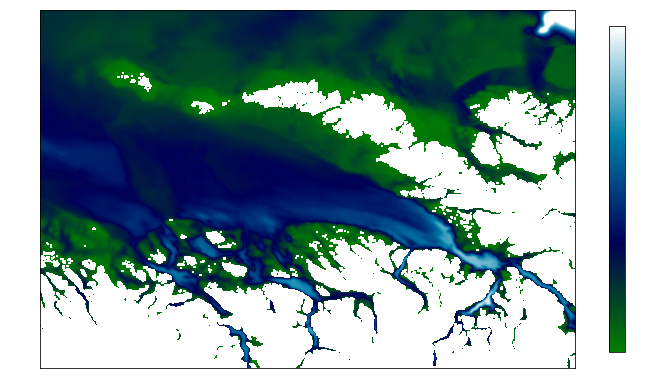

In [7]:
plt.figure(figsize=(12,8))
plt.imshow(Hm_orig, vmax=750, cmap="ocean")
plt.colorbar(shrink=0.75)

## Coarest bathymetry information

In [8]:
data_args = NetCDFInitialization.rescaleInitialConditions(nf160_data_args, 1/5)
data_args["eta0"].shape

(200, 300)

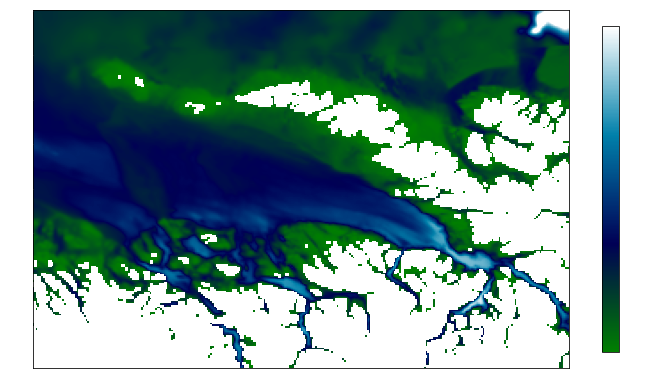

In [9]:
plt.figure(figsize=(12,8))
plt.imshow(data_args["H"], vmax=750, cmap="ocean")
plt.colorbar(shrink=0.75)

## Multi resolution simulation

In [10]:
from gpuocean.SWEsimulators import CDKLM16

In [11]:
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [12]:
Hm_data = sim.bathymetry.Bm.data.get()
Hm_mask = (Hm_data == 1.0e20)
Hm = np.ma.array(Hm_data, mask=Hm_mask)

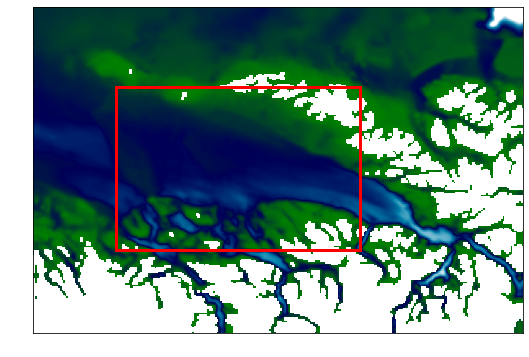

In [13]:
loc = [[50, 50], [150,200]]
scale = 1.2

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(Hm, vmax=750, cmap="ocean")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='red', facecolor='none', lw=3)
ax.add_patch(area)

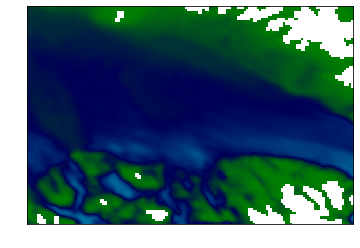

In [14]:
plt.imshow(Hm[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], vmax=750, cmap="ocean")

Find fine area (see model error for averaging over floating numbers)

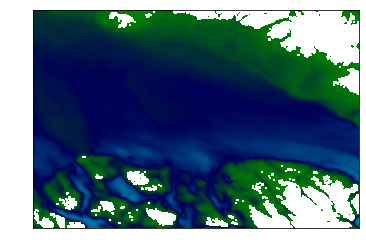

In [15]:
# Hm_orig has halo of 1 cell
Hm_loc_fine = Hm_orig[5*loc[0][0] : 5*loc[1][0]+2, 5*loc[0][1] : 5*loc[1][1]+2]
plt.imshow(Hm_loc_fine, vmax=750, cmap="ocean")

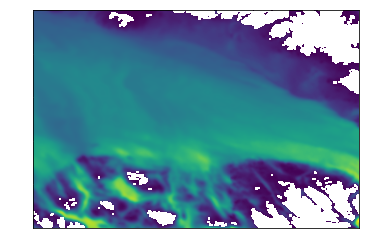

In [16]:
Hi_loc_fine = OceanographicUtilities.midpointsToIntersections(Hm_loc_fine)[0]
plt.imshow(Hi_loc_fine)

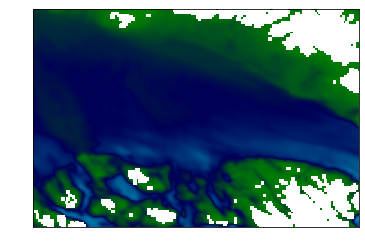

In [17]:
# as long as coarsening it is without minmod
Hi_loc_level = OceanographicUtilities.rescaleIntersections(Hm_loc_fine, 181, 121)[2]
plt.imshow(Hi_loc_level, vmax=750, cmap="ocean")

Interpolation: First interpolate Midpoints and then go to intersections

In [88]:
from scipy import interpolate 

In [89]:
Hm_orig.shape

(1002, 1502)

In [90]:
x0 = np.linspace(0.5*nf160_data_args["dx"], (Hm_orig.shape[1]-0.5)*nf160_data_args["dx"], Hm_orig.shape[1])
y0 = np.linspace(0.5*nf160_data_args["dy"], (Hm_orig.shape[0]-0.5)*nf160_data_args["dy"], Hm_orig.shape[0])

interp = interpolate.interp2d(x0, y0, Hm_orig, kind="linear")

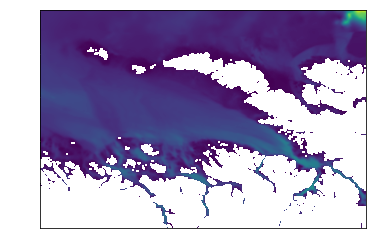

In [91]:
plt.imshow(np.ma.array(interp(x0,y0), mask=(interp(x0,y0)<5.1)))

In [92]:
ny_loc, nx_loc = np.int32(scale*(np.array(loc[1])-np.array(loc[0])))
dx_loc, dy_loc = 800/1.2, 800/1.2

In [93]:
global_local_area = [[loc[0][0]/(sim.ny+4), loc[0][1]/(sim.nx+4)],[loc[1][0]/(sim.ny+4),loc[1][1]/(sim.nx+4)]]

In [94]:
# offset 1 for halo in Hm_orig
x1 = np.linspace((1.0+global_local_area[0][1]*(Hm_orig.shape[1]-2))*nf160_data_args["dx"]-2.5*dx_loc, (1.0+global_local_area[1][1]*(Hm_orig.shape[1]-2))*nf160_data_args["dx"]+2.5*dx_loc, nx_loc+6)
y1 = np.linspace((1.0+global_local_area[0][0]*(Hm_orig.shape[0]-2))*nf160_data_args["dy"]-2.5*dx_loc, (1.0+global_local_area[1][0]*(Hm_orig.shape[0]-2))*nf160_data_args["dy"]+2.5*dy_loc, ny_loc+6)
# with ghost cells and 1-cell halo

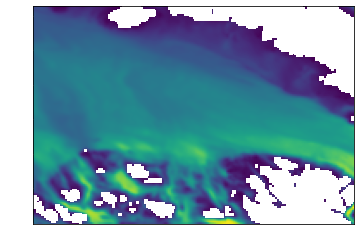

In [95]:
Hm_loc_data = np.ma.zeros((ny_loc+6, nx_loc+6))
Hm_loc_mask = np.zeros((ny_loc+6, nx_loc+6), dtype=bool)

Hm_quart =  1/4*interp(x1-0.25*dx_loc, y1-0.25*dy_loc)
Hm_loc_data += Hm_quart
Hm_loc_mask = np.logical_or(Hm_loc_mask, Hm_quart<=5.0)

Hm_quart =  1/4*interp(x1-0.25*dx_loc, y1+0.25*dy_loc)
Hm_loc_data += Hm_quart
Hm_loc_mask = np.logical_or(Hm_loc_mask, Hm_quart<=5.0)

Hm_quart =  1/4*interp(x1+0.25*dx_loc, y1+0.25*dy_loc)
Hm_loc_data += Hm_quart
Hm_loc_mask = np.logical_or(Hm_loc_mask, Hm_quart<=5.0)

Hm_quart =  1/4*interp(x1+0.25*dx_loc, y1-0.25*dy_loc)
Hm_loc_data += Hm_quart
Hm_loc_mask = np.logical_or(Hm_loc_mask, Hm_quart<=5.0)

Hm_loc = np.ma.array(Hm_loc_data, mask=Hm_loc_mask)
plt.imshow(Hm_loc)

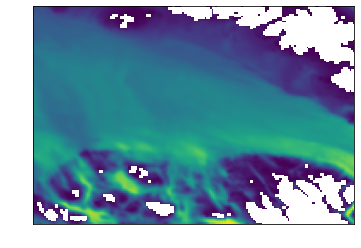

In [96]:
Hm_loc_data = interp(x1, y1)
Hm_loc_mask = (Hm_loc_data<=5.1)

Hm_loc = np.ma.array(Hm_loc_data, mask=Hm_loc_mask)
plt.imshow(Hm_loc)

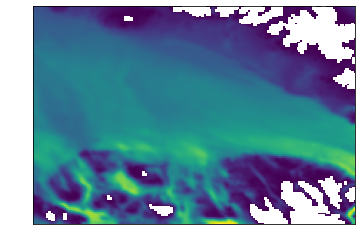

In [99]:
# METHOD OF CHOICE!!!
Hi_loc = OceanographicUtilities.midpointsToIntersections(Hm_loc)[0]
plt.imshow(Hi_loc)

In [98]:
Hi_loc.shape

(125, 185)

Interpolation: First go to intersections and interpolate then

In [65]:
Hi_orig = nf160_data_args["H"]

In [66]:
x0 = np.linspace(nf160_data_args["dx"], (Hi_orig.shape[1])*nf160_data_args["dx"], Hi_orig.shape[1])
y0 = np.linspace(nf160_data_args["dy"], (Hi_orig.shape[0])*nf160_data_args["dy"], Hi_orig.shape[0])

interp = interpolate.interp2d(x0, y0, Hi_orig, kind="linear")

In [67]:
# offset 1 for halo in Hm_orig
x1 = np.linspace((global_local_area[0][1]*(Hi_orig.shape[1]))*nf160_data_args["dx"]-2*dx_loc, (global_local_area[1][1]*(Hi_orig.shape[1]))*nf160_data_args["dx"]+2*dx_loc, nx_loc+5)
y1 = np.linspace((global_local_area[0][0]*(Hi_orig.shape[0]))*nf160_data_args["dy"]-2*dx_loc, (global_local_area[1][0]*(Hi_orig.shape[0]))*nf160_data_args["dy"]+2*dy_loc, ny_loc+5)
# with ghost cells and 1-cell halo

In [83]:
Hi_loc_data =  interp(x1, y1)
Hi_loc_mask = (Hi_loc_data <= 5.1)
Hi_loc = np.ma.array(Hi_loc_data, mask=Hi_loc_mask)

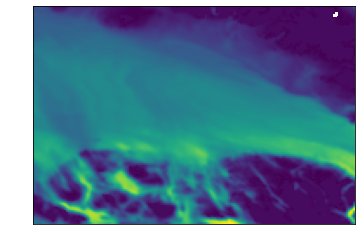

In [84]:
plt.imshow(Hi_loc)